## COMPARING DEEP Q-NETWORKS AND VAIRANTS ON ATARI.

**The actual implementation of the project required mutliple google colab files on multiple accounts running parallely on GPU and the model weights had to be saved multiple times for each game environment.**

**This notebook includes the base code which could be used to re-create the results by modifying the commented sections.**

In [ ]:
# pip install 'gym [atari,accept-rom-license]==0.21.0'

## Please install the Pytorch library on your computer before you run this notebook.

The installation instructions can be found here. (https://pytorch.org/get-started/locally/)

In [ ]:
import torch
import tqdm
import random
import gym
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from gym.wrappers import AtariPreprocessing, FrameStack

In [ ]:
from gym.version import VERSION
print(VERSION)

0.21.0


## Define a Deep Q network

Before, we write a DQN agent. Let's define a Deep Q network as we did in Q1. Otherwise, you could also adapt your
implementation above.

In [ ]:
# customized weight initialization
def customized_weights_init(m):
    # compute the gain
    gain = nn.init.calculate_gain('relu')
    # init the convolutional layer
    if isinstance(m, nn.Conv2d):
        # init the params using uniform
        nn.init.xavier_uniform_(m.weight, gain=gain)
        nn.init.constant_(m.bias, 0)
    # init the linear layer
    if isinstance(m, nn.Linear):
        # init the params using uniform
        nn.init.xavier_uniform_(m.weight, gain=gain)
        nn.init.constant_(m.bias, 0)

## Define a Experience Replay Buffer

One main contribution of DQN is proposing to use the replay buffer. Here is the implementation of a simple replay buffer as a list of transitions (i.e., [(s, a, r, s', d), ....]).

In [ ]:
class ReplayBuffer(object):
    """ Implementing the Replay Buffer as a class, which contains:
            - self._data_buffer (list): a list variable to store all transition tuples.
            - add: a function to add new transition tuple into the buffer
            - sample_batch: a function to sample a batch training data from the Replay Buffer
    """
    def __init__(self, buffer_size):
        """Args:
               buffer_size (int): size of the replay buffer
        """
        # total size of the replay buffer
        self.total_size = buffer_size

        # create a list to store the transitions
        self._data_buffer = []
        self._next_idx = 0

    def __len__(self):
        return len(self._data_buffer)

    def add(self, obs, act, reward, next_obs, done):
        # create a tuple
        trans = (obs, act, reward, next_obs, done)

        # interesting implementation
        if self._next_idx >= len(self._data_buffer):
            self._data_buffer.append(trans)
        else:
            self._data_buffer[self._next_idx] = trans

        # increase the index
        self._next_idx = (self._next_idx + 1) % self.total_size

    def _encode_sample(self, indices):
        """ Function to fetch the state, action, reward, next state, and done arrays.

            Args:
                indices (list): list contains the index of all sampled transition tuples.
        """
        # lists for transitions
        obs_list, actions_list, rewards_list, next_obs_list, dones_list = [], [], [], [], []

        # collect the data
        for idx in indices:
            # get the single transition
            data = self._data_buffer[idx]
            obs, act, reward, next_obs, d = data
            # store to the list
            obs_list.append(np.array(obs, copy=False))
            actions_list.append(np.array(act, copy=False))
            rewards_list.append(np.array(reward, copy=False))
            next_obs_list.append(np.array(next_obs, copy=False))
            dones_list.append(np.array(d, copy=False))
        # return the sampled batch data as numpy arrays
        return np.array(obs_list), np.array(actions_list), np.array(rewards_list), np.array(next_obs_list), np.array(
            dones_list)

    def sample_batch(self, batch_size):
        """ Args:
                batch_size (int): size of the sampled batch data.
        """
        # sample indices with replaced
        indices = [np.random.randint(0, len(self._data_buffer)) for _ in range(batch_size)]
        return self._encode_sample(indices)

In [ ]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        It's important to make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

## Define a shedule for epsilon-greedy policy

Here, we define a shedule function to return the epsilon for each time step t.

In [ ]:
#in DQN Linear decay rate is used so comment this.

# class LinearSchedule(object):
#     """ This schedule returns the value linearly"""
#     def __init__(self, start_value, end_value, duration):
#         # start value
#         self._start_value = start_value
#         # end value
#         self._end_value = end_value
#         # time steps that value changes from the start value to the end value
#         self._duration = duration
#         # difference between the start value and the end value
#         self._schedule_amount = start_value - end_value

#     def get_value(self, time):
#         # logic: if time > duration, use the end value, else use the scheduled value
#         """ CODE HERE: return the epsilon for each time step within the duration.
#         """
#         if time > self._duration:
#             return self._end_value
#         else:
#             # base_lr * ((1 - float(iter) / max_iter) ** power)
#             power = 1
#             self._schedule_amount = self._start_value * ((1 - float(time) / self._duration) ** power)
#             return round(self._schedule_amount, 4)

### Exploring Atari Pong

In [ ]:
test_env = gym.make("BoxingNoFrameskip-v4")

In [ ]:
print("Action space size: ", test_env.action_space.n)
print("Action space desc: ", test_env.unwrapped.get_action_meanings())

Action space size:  18
Action space desc:  ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


In [ ]:
print("Display resolution: ", test_env.observation_space.shape)

Display resolution:  (210, 160, 3)


## Neural Network

## Define the DQN agent

## Preprocessing

In [ ]:
import cv2
import numpy as np
import collections

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.integers(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        #or NoopResetEnv
        # noops = (self.env.unwrapped.np_random.integers(1, 31)
        #     if self.noop_max > 0
        #     else 0)
        # for _ in range(noops):
        #     _, _, terminated, truncated, step_info = self.env.step(0)
        #     reset_info.update(step_info) #better to Global time step update, maybe doesn't matter that much
        #     if terminated or truncated:
        #         _, reset_info = self.env.reset()

        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 210 * 160 * 3:
            img = np.reshape(frame, [210, 160, 3]).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
            img = np.reshape(frame, [250, 160, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1],
                                old_shape[0], old_shape[1]), dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

def make_env(env_name):
    env = gym.make(env_name)
    env = NoopResetEnv(env)
    env = MaxAndSkipEnv(env)
    env = FireResetEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    return ScaledFloatFrame(env)

In [ ]:
####COMMENT THIS CELL TO USE DUELING ARCHITECTURE BELOW
####ARCHITECTURE FOR DQN AND DDQN

import torchvision
from PIL import Image
class DeepQNet(nn.Module):
    def __init__(self, input_dim, dim_hidden_layer, output_dim):
        super(DeepQNet, self).__init__()


        # define the input dimension
        self.input_dim = input_dim

        # define the number of the hidden layers
        self.hidden_dim = dim_hidden_layer

        # define the output dimension
        self.output_dim = output_dim

        self.conv = nn.Sequential(
            nn.Conv2d(input_dim[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(self.input_dim)
        # print(conv_out_size)
        # o = self.conv(torch.zeros(1, *self.input_dim))
        # conv_out_size = int(np.prod(o.size()))
        #Single clip
        self.fc = nn.Sequential(
                nn.Linear(conv_out_size, 512),
                nn.ReLU(),
                nn.Linear(512, output_dim)
            )

    # In order to code a generic model (for all the games) that can accept different input shape, we will use a simple function, _get_conv_out()
    # that accepts the input shape and applies the convolution layer to a fake tensor of such a shape
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)


In [ ]:
#ARCHITECTURE FOR DUELING DDQN

# import torchvision
# from PIL import Image
# class DeepQNet(nn.Module):
#     def __init__(self, input_dim, dim_hidden_layer, output_dim):
#         super(DeepQNet, self).__init__()

#         """CODE HERE: construct your Deep neural network
#         """
#         # define the input dimension
#         self.input_dim = input_dim

#         # define the number of the hidden layers
#         self.hidden_dim = dim_hidden_layer

#         # define the output dimension
#         self.output_dim = output_dim

#         self.conv = nn.Sequential(
#             nn.Conv2d(input_dim[0], 32, kernel_size=8, stride=4),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=4, stride=2),
#             nn.ReLU(),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1),
#             nn.ReLU()
#         )

#         conv_out_size = self._get_conv_out(self.input_dim)
#         # print(conv_out_size)
#         # o = self.conv(torch.zeros(1, *self.input_dim))
#         # conv_out_size = int(np.prod(o.size()))

#         self.fc_state = nn.Sequential(
#                 nn.Linear(conv_out_size, 512),
#                 nn.ReLU(),
#                 nn.Linear(512, 1)
#             )

#         self.fc_action = nn.Sequential(
#                 nn.Linear(conv_out_size, 512),
#                 nn.ReLU(),
#                 nn.Linear(512, output_dim)
#             )

#     #For single clip DDQN, change the final dimension to 1024 for proper comparison with DDDQN

#     # In order to code a generic model (for all the games) that can accept different input shape, we will use a simple function, _get_conv_out()
#     # that accepts the input shape and applies the convolution layer to a fake tensor of such a shape
#     def _get_conv_out(self, shape):
#         o = self.conv(torch.zeros(1, *shape))
#         return int(np.prod(o.size()))

#     def forward(self, x):
#         conv_out = self.conv(x).view(x.size()[0], -1)

#         fstate = self.fc_state(conv_out)
#         faction = self.fc_action(conv_out)

#         actn = faction - faction.mean(dim=-1, keepdim=True)
#         # $Q(s, a) =V(s) + \Big(A(s, a) - \frac{1}{|\mathcal{A}|} \sum_{a' \in \mathcal{A}} A(s, a')\Big)$
#         q = fstate + actn

#         return q


In [ ]:
DeepQNet((4, 84, 84), 32, 6)

DeepQNet(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [ ]:
class DQNAgent(object):
    # initialize the agent
    def __init__(self,
                 params,
                 ):
        # save the parameters
        self.params = params

        # environment parameters
        self.action_dim = params['action_dim']
        self.obs_dim = params['observation_dim']

        # executable actions
        self.action_space = params['action_space']

        # create behavior policy network
        self.behavior_policy_net = DeepQNet(input_dim=params['observation_dim'],
                                            dim_hidden_layer=params['hidden_layer_dim'],
                                            output_dim=params['action_dim'])
        # create target network
        self.target_policy_net = DeepQNet(input_dim=params['observation_dim'],
                                          dim_hidden_layer=params['hidden_layer_dim'],
                                          output_dim=params['action_dim'])

        # initialize target network with behavior network
        self.behavior_policy_net.apply(customized_weights_init)
        self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())

        # send the agent to a specific device: cpu or gpu
        self.device = torch.device("cuda")
        self.behavior_policy_net.to(self.device)
        self.target_policy_net.to(self.device)

        # optimizer
        self.optimizer = torch.optim.Adam(self.behavior_policy_net.parameters(), lr=params['learning_rate'])

        # self.loss_fn = nn.MSELoss(reduction='mean')
        self.loss_fn = nn.SmoothL1Loss(reduction='mean')


    # get action
    def get_action(self, obs, eps):
        if np.random.random() < eps:  # with probability eps, the agent selects a random action
            action = self.action_space.sample()
        else:  # with probability 1 - eps, the agent selects a greedy policy
            obs = self._arr_to_tensor(obs) #.view(1, -1)
            with torch.no_grad():
                q_values = self.behavior_policy_net(obs)
                action = q_values.max(dim=1)[1].item()
        return action

    # update behavior policy
    def update_behavior_policy(self, batch_data):
        # convert batch data to tensor and put them on device
        batch_data_tensor = self._batch_to_tensor(batch_data)

        # get the transition data
        obs_tensor = batch_data_tensor['obs']
        actions_tensor = batch_data_tensor['action']
        next_obs_tensor = batch_data_tensor['next_obs']
        rewards_tensor = batch_data_tensor['reward']
        dones_tensor = batch_data_tensor['done']


        #DOUBLE Q-LEARNING BEHAVIOR NETWORK UPDATE

        # q_val_b = self.behavior_policy_net(obs_tensor)

        # with torch.no_grad():
        #   q_val_t = self.target_policy_net(next_obs_tensor)
        #   target_q_val = q_val_b.clone().detach()

        #   actions_tensor = actions_tensor.reshape((actions_tensor.shape[0],))

        #   q_val_bn = self.behavior_policy_net(next_obs_tensor)

        #   actn = torch.argmax(q_val_bn,dim=1)
        #   indices = np.arange(actions_tensor.shape[0])
        #   q_next_val = (q_val_t[indices, actn]).view(-1,1)

        #   # compute the TD target using the target network

        #   target_q_val[indices, actions_tensor] = (rewards_tensor + self.params['gamma'] *(1 - dones_tensor) *
        #                                     (q_next_val).detach().view(-1, 1)).reshape((actions_tensor.shape[0],))
        # # compute the loss
        # td_loss = self.loss_fn(q_val_b,target_q_val)

        #loss = torch.mean(weights * losses)




        #DQN BEHAVIOR NETWORK UPDATE....COMMMENT FOR USING DDQN OR DUELING DDQN

        # compute the q value estimation using the behavior network
        Q_behaviour = self.behavior_policy_net(obs_tensor).gather(1, actions_tensor)

        '''gather will index the rows of the q-values (i.e. the per-sample q-values in a batch of q-values)
        by the batch-list of actions. The result will be the same as if you had done the following
        (though it will be much faster than a loop):'''

        with torch.no_grad():
          # compute the TD target using the target network
          Q_target_next = self.target_policy_net(next_obs_tensor).detach().max(1)[0].unsqueeze(1)
          Q_targets = rewards_tensor + (self.params["gamma"] * Q_target_next * (1 - dones_tensor))

        # compute the loss
        td_loss = self.loss_fn(Q_behaviour, Q_targets) # me

        # minimize the loss
        self.optimizer.zero_grad()
        td_loss.backward()

        #UNCOMMENT FOR DUELING DDQN
        # torch.nn.utils.clip_grad_norm_(self.behavior_policy_net.parameters(), max_norm=10)

        self.optimizer.step()

        return td_loss.item()

    # update update target policy
    def update_target_policy(self):
        # hard update
        """CODE HERE:
                Copy the behavior policy network to the target network
        """
        self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())

    # load trained model
    def load_model(self, model_file):
        # load the trained model
        self.behavior_policy_net.load_state_dict(torch.load(model_file, map_location=self.device))
        self.behavior_policy_net.eval()
        self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())
        print("here")

    # auxiliary functions
    def _arr_to_tensor(self, arr):
        # arr = np.array(arr)
        # arr_tensor = torch.from_numpy(arr).float().to(self.device)

        arr = np.array([arr], copy=False)
        arr_tensor = torch.tensor(arr).to(self.device)
        return arr_tensor

    def _batch_to_tensor(self, batch_data):
        # store the tensor
        batch_data_tensor = {'obs': [], 'action': [], 'reward': [], 'next_obs': [], 'done': []}
        # get the numpy arrays
        obs_arr, action_arr, reward_arr, next_obs_arr, done_arr = batch_data
        # convert to tensors
        batch_data_tensor['obs'] = torch.tensor(obs_arr, dtype=torch.float32).to(self.device)
        batch_data_tensor['action'] = torch.tensor(action_arr).long().view(-1, 1).to(self.device)
        batch_data_tensor['reward'] = torch.tensor(reward_arr, dtype=torch.float32).view(-1, 1).to(self.device)
        batch_data_tensor['next_obs'] = torch.tensor(next_obs_arr, dtype=torch.float32).to(self.device)
        batch_data_tensor['done'] = torch.tensor(done_arr, dtype=torch.float32).view(-1, 1).to(self.device)

        return batch_data_tensor

## Define the training process

In [ ]:
from google.colab import files
import pickle

import gym.spaces, cv2

def train_dqn_agent(env, params):
    # create the DQN agent
    my_agent = DQNAgent(params)

    # my_agent.load_model("KrullNoFrameskip-v4_duel.pt")


    # create the epsilon-greedy schedule
    # my_schedule = LinearSchedule(start_value=params['epsilon_start_value'],
    #                              end_value=params['epsilon_end_value'],
    #                              duration=params['epsilon_duration'])

    eps_t = 1.0

    # create the replay buffer
    replay_buffer = ReplayBuffer(params['replay_buffer_size'])

    # training variables
    episode_t = 0
    rewards = []
    train_returns = []
    train_loss = []
    loss = 0

    # reset the environment
    obs = env.reset()

    # start training
    pbar = tqdm.trange(params['total_training_time_step'])
    last_best_return = 0
    for t in pbar:
        # scheduled epsilon at time step t
        if eps_t > 0.01:
          eps_t -= 0.255e-6 #1.15e-6 more exploitation but then again....0.43 for boxing

        # get one epsilon-greedy action
        action = my_agent.get_action(obs, eps_t)

        # step in the environment
        next_obs, reward, done, _ = env.step(action)

        # add to the buffer
        replay_buffer.add(obs, action, reward, next_obs, done)
        rewards.append(reward)


        # if t%1000_000==0 and t!=0:
        #     train_lists = [train_returns, train_loss]
        #     print(len(train_loss))
        #     print(len(train_returns))
        #     with open('RL_DQN_data_krull_duel_1M_data', 'wb') as file:
        #         pickle.dump(train_lists, file)
        #     files.download('RL_DQN_data_krull_duel_1M_data')
        #     files.download('KrullNoFrameskip-v4_duel.pt')



        # if t%3499_999==0 and t!=0:
        #     train_lists = [train_returns, train_loss]
        #     print(len(train_loss))
        #     print(len(train_returns))
        #     with open('RL_DQN_data_krull_duel_3.5M_data', 'wb') as file:
        #         pickle.dump(train_lists, file)
        #     files.download('RL_DQN_data_krull_duel_3.5M_data')
        #     files.download('KrullNoFrameskip-v4_duel.pt')



        # check termination
        if done or t == params['max_time_step_per_episode'] - 1:
            # compute the return
            G = 0
            for r in reversed(rewards):
                G = r + G

            if G > last_best_return:
                torch.save(my_agent.behavior_policy_net.state_dict(), f"./{params['model_name']}")
                last_best_return = G



            # store the return
            train_returns.append(G)
            episode_idx = len(train_returns)

            # print the information
            pbar.set_description(
                f"Ep={episode_idx} | "
                f"G={np.mean(train_returns[-10:]) if train_returns else 0:.2f} | "
                f"Eps={eps_t}"
            )

            # reset the environment
            episode_t, rewards = 0, []
            obs = env.reset()

        else:
            # increment
            obs = next_obs
            episode_t += 1

        if t > params['start_training_step']:
            # update the behavior model
            if not np.mod(t, params['freq_update_behavior_policy']):
                """ CODE HERE:
                    Update the behavior policy network
                """
                batch = replay_buffer.sample_batch(params["batch_size"])
                loss = my_agent.update_behavior_policy(batch)

                # store the loss
                train_loss.append(loss)

            # update the target model
            if not np.mod(t, params['freq_update_target_policy']):
                """ CODE HERE:
                    Update the behavior policy network
                """
                my_agent.update_target_policy()

    # save the results
    return train_returns, train_loss

In [ ]:
episode_t = 0
if episode_t%1000_000==0:
  print("hello")

hello


In [ ]:
Almost DQN
def update_behavior_policy(self, batch_data):
    # convert batch data to tensor and put them on device
    batch_data_tensor = self._batch_to_tensor(batch_data)

    # get the transition data
    obs_tensor = batch_data_tensor['obs']
    actions_tensor = batch_data_tensor['action']
    next_obs_tensor = batch_data_tensor['next_obs']
    rewards_tensor = batch_data_tensor['reward']
    dones_tensor = batch_data_tensor['done']

    """CODE HERE:
            Compute the predicted Q values using the behavior policy network
    """
    # compute the q value estimation using the behavior network
    Q_behaviour = self.behavior_policy_net(obs_tensor).gather(1, actions_tensor)

    '''gather will index the rows of the q-values (i.e. the per-sample q-values in a batch of q-values)
    by the batch-list of actions. The result will be the same as if you had done the following
    (though it will be much faster than a loop):'''

    # compute the TD target using the target network
    Q_target_next = self.target_policy_net(next_obs_tensor).detach().max(1)[0].unsqueeze(1)
    Q_targets = rewards_tensor + (self.params["gamma"] * Q_target_next * (1 - dones_tensor))

    # compute the loss
    td_loss = self.loss_fn(Q_behaviour, Q_targets) # me

    # minimize the loss
    self.optimizer.zero_grad()
    td_loss.backward()
    self.optimizer.step()

    return td_loss.item()


In [ ]:
if __name__ == '__main__':
    # set the random seed
    np.random.seed(1234)
    random.seed(1234)
    torch.manual_seed(1234)

    # create environment
    my_env = make_env("PongNoFrameskip-v4")
    # create training parameters
    train_parameters = {
        'observation_dim': my_env.observation_space.shape,
        'action_dim': my_env.action_space.n,
        'action_space': my_env.action_space,
        'hidden_layer_dim': 32,
        'gamma': 0.999,

        'max_time_step_per_episode': 5000, #not compulsory, not used

        'total_training_time_step': 1000000,

        'epsilon_start_value': 1.0,
        'epsilon_end_value': 0.01,
        'epsilon_duration': 250_000,

        'replay_buffer_size': 50000, #before 25k
        'start_training_step': 2500, # before 2k
        'freq_update_behavior_policy': 4,
        'freq_update_target_policy': 3000, #before 10k

        'batch_size': 32,
        'learning_rate': 3e-4, #3e-4 for pong

        'model_name': "PongNoFrameskip_duel.pt"
    }



    create experiment
    train_returns, train_loss = train_dqn_agent(my_env, train_parameters)


# agent = DuelingDDQNAgent(gamma=0.99, epsilon=1.0, lr=0.0001,
#                     input_dims=(env.observation_space.shape),
#                     n_actions=env.action_space.n, mem_size=50000, eps_min=0.1,
#                     batch_size=32, replace=10000, eps_dec=1e-5,
#                     chkpt_dir='models/', algo='DuelingDDQNAgent',
#                     env_name='PongNoFrameskip-v4')


# configs = {
#     # Number of updates
#     'updates': 1_000_000,
#     # Number of epochs to train the model with sampled data.
#     'epochs': 8,
#     # Number of worker processes
#     'n_workers': 8,
#     # Number of steps to run on each process for a single update
#     'worker_steps': 4,
#     # Mini batch size
#     'mini_batch_size': 32,
#     # Target model updating interval
#     'update_target_model': 250,
#     # Learning rate.
#     'learning_rate': FloatDynamicHyperParam(1e-4, (0, 1e-3)),
# }


# DQN_HYPERPARAMS = {
# 	'dueling': False,
# 	'noisy_net': False,
# 	'double_DQN': False,
# 	'n_multi_step': 2,
# 	'buffer_start_size': 10001,
# 	'buffer_capacity': 15000,
# 	'epsilon_start': 1.0,
# 	'epsilon_decay': 10**5,
# 	'epsilon_final': 0.02,
# 	'learning_rate': 5e-5,
# 	'gamma': 0.99,
# 	'n_iter_update_target': 1000
# }


# self,
# n_actions,
# n_features,
# learning_rate=0.001,
# reward_decay=0.9,
# e_greedy=0.9,
# replace_target_iter=200,
# memory_size=500,
# batch_size=32,
# e_greedy_increment=None,
# output_graph=False,
# dueling=True,
# sess=None,



# RANDOM_SEED = 0
# torch.manual_seed(RANDOM_SEED)
# env.seed(RANDOM_SEED)
# np.random.seed(RANDOM_SEED)
# random.seed(RANDOM_SEED)


#Reeward clipping.......

# if __name__ == '__main__':
#     # set the random seed
#     np.random.seed(1234)
#     random.seed(1234)
#     torch.manual_seed(1234)

#     # create environment
#     # my_env = make_env("PongDeterministic-v4")
#     my_env = make_env("KrullNoFrameskip-v4")
#     # create training parameters
#     train_parameters = {
#         'observation_dim': my_env.observation_space.shape,
#         'action_dim': my_env.action_space.n,
#         'action_space': my_env.action_space,
#         'hidden_layer_dim': 32,
#         'gamma': 0.99,

#         'max_time_step_per_episode': 25000,

#         'total_training_time_step': 5000_000,

#         'epsilon_start_value': 1.0,
#         'epsilon_end_value': 0.01,
#         'epsilon_duration': 250_000,

#         'replay_buffer_size': 50000,
#         'start_training_step': 5000,
#         'freq_update_behavior_policy': 4,
#         'freq_update_target_policy': 10_000,

#         'batch_size': 32,
#         'learning_rate': 2.25e-4,
#         'model_name': "KrullNoFrameskip-v4_dqn_5M.pt"
#     }

#     # create experiment
#     train_returns, train_loss = train_dqn_agent(my_env, train_parameters)


Ep=981 | G=19.40 | Eps=0.009999519973184223: 100%|██████████| 1500000/1500000 [2:00:33<00:00, 207.36it/s]


In [ ]:
#Save the models weights

train_lists = [train_returns, train_loss]
print(len(train_loss))
print(len(train_returns))
with open('PongNoFrameskip_duel.pt', 'wb') as file:
    pickle.dump(train_lists, file)
files.download('PongNoFrameskip_duel.pt')
# files.download('BoxingNoFrameskip-v4_duel_2M_0.7L.pt')

In [ ]:
#Save the model weights

# train_lists = [train_returns, train_loss]
# print(len(train_loss))
# print(len(train_returns))
# with open('RL_DQN_data_krull_dqn_5M1_data', 'wb') as file:
#     pickle.dump(train_lists, file)
# files.download('RL_DQN_data_krull_dqn_5M1_data')
# files.download('KrullNoFrameskip-v4_dqn_5M.pt')


In [ ]:
# train_lists = [train_returns, train_loss]
# print(len(train_loss))
# print(len(train_returns))
# with open('RL_DQN_data_Boxing_duel_2M1_0.7L', 'wb') as file:
#     pickle.dump(train_lists, file)
# files.download('RL_DQN_data_Boxing_duel_2M1_0.7L')
# files.download('BoxingNoFrameskip-v4_duel_2M_0.7L.pt')

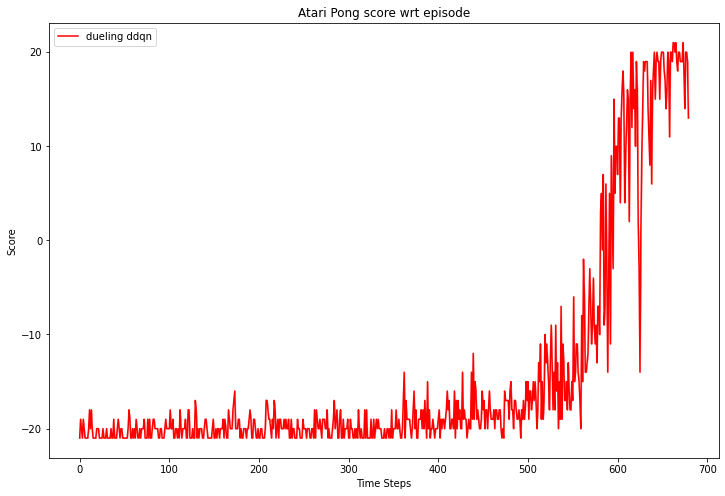

In [ ]:
plot_curves([np.array([train_returns])], ['dueling ddqn'], ['r'], 'Score', 'Atari Pong score wrt episode')

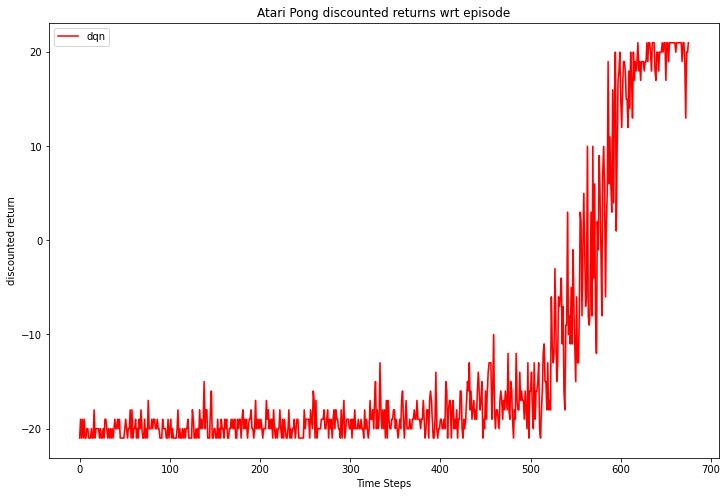

In [ ]:
plot_curves([np.array([train_returns])], ['dqn'], ['r'], 'discounted return', 'Atari Pong discounted returns wrt episode')

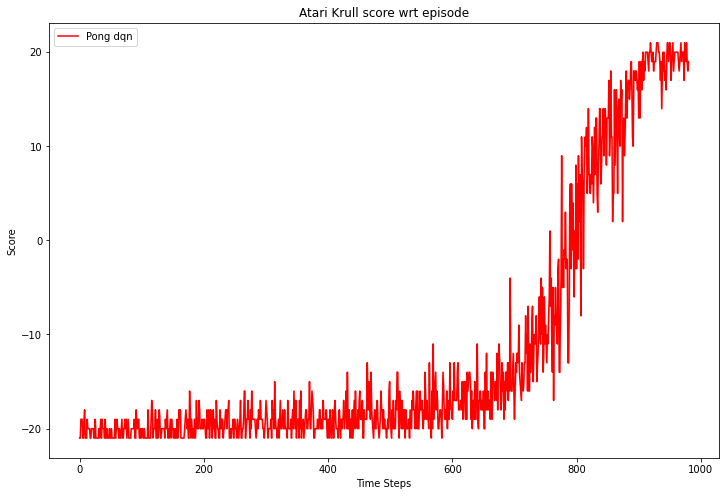

In [ ]:
plot_curves([np.array([train_returns])], ['Pong dqn'], ['r'], 'Score', 'Atari Krull score wrt episode')

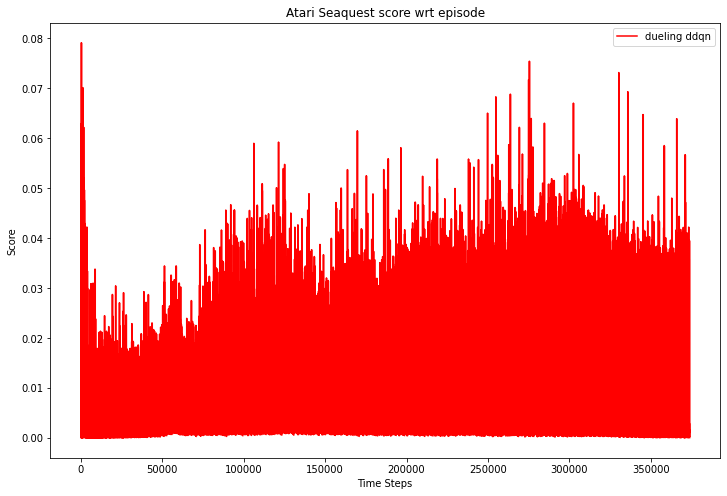

In [ ]:
plot_curves([np.array([train_loss])], ['dueling ddqn'], ['r'], 'Score', 'Atari Seaquest score wrt episode')

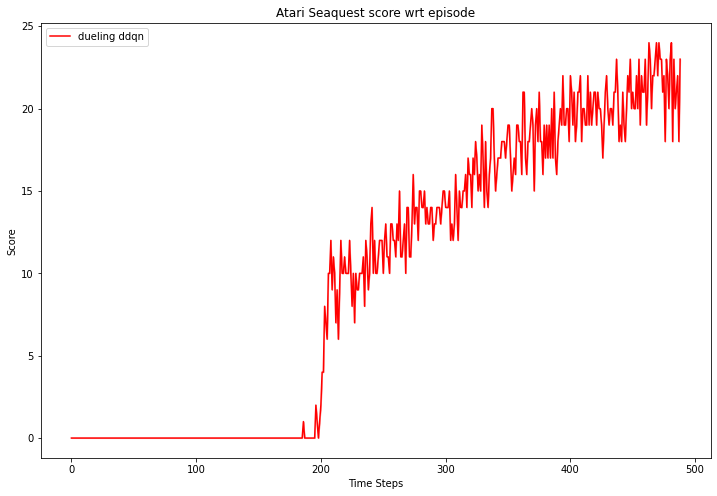

In [ ]:
plot_curves([np.array([train_returns])], ['dueling ddqn'], ['r'], 'Score', 'Atari Seaquest score wrt episode')

In [ ]:
from statistics import mean

my_env = make_env("PongNoFrameskip-v4")
my_agent = DQNAgent(train_parameters)
my_agent.load_model("PongNoFrameskip.pt")

e_sum=[]

np.random.seed(1234)
random.seed(1234)
torch.manual_seed(1234)


for episode in range(100):
    done = False
    sum_reward=0
    i=0
    obs = my_env.reset()
    while not done and i < train_parameters['max_time_step_per_episode']:
      action = my_agent.get_action(obs, 0.05)
      next_obs, reward, done,_ = my_env.step(action)
      sum_reward += reward
      obs = next_obs
      i += 1
    e_sum.append(sum_reward)
    print()
    print(sum_reward)
    print()
print(sum(e_sum)/5)

In [ ]:
my_agent.load_model("PongNoFrameskip.pt")
print

None


In [ ]:
from google.colab import files
import pickle

train_lists = [train_returns, train_loss]

with open('RL_DQN_data_freeway_ddqn_1M', 'wb') as file:
    pickle.dump(train_lists, file)

files.download('RL_DQN_data_freeway_ddqn_1M')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
import pickle

with open('RL_DQN_data_freeway_ddqn_1M', 'rb') as file:
    dd = pickle.load(file)

In [ ]:
len(dd[0])

489

In [ ]:
# plot_curves([np.array([train_returns])], ['Krull dqn'], ['r'], 'Score', 'Atari Krull score wrt episode')

In [ ]:
# plot_curves([np.array([train_returns])], ['dueling ddqn'], ['r'], 'Score', 'Atari Pong score wrt episode')

In [ ]:
# plot_curves([np.array([train_returns])], ['dqn'], ['r'], 'discounted return', 'Atari Pong discounted returns wrt episode')

In [ ]:
# plot_curves([np.array([train_returns])], ['dqn'], ['r'], 'discounted return', 'Atari Pong discounted returns wrt episode')

In [ ]:
# plot_curves([np.array([train_returns])], ['dueling ddqn'], ['r'], 'Score', 'Atari Seaquest score wrt episode')